# How To Backtest Machine Learning Models for Time Series Forecasting
The goal of time series forecasting is to make accurate predictions about the future.

The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.

In this tutorial, you will discover how to evaluate machine learning models on time series data with Python. In the field of time series forecasting, this is called backtesting or hindcasting.

After completing this tutorial, you will know:

* The limitations of traditional methods of model evaluation from machine learning and why evaluating models on out of sample data is required.
* How to create train-test splits and multiple train-test splits of time series data for model evaluation in Python.
* How walk-forward validation provides the most realistic evaluation of machine learning models on time series data.

Let’s get started.

## Model Evaluation
How do we know how good a given model is?

We could evaluate it on the data used to train it. This would be invalid. It might provide insight into how the selected model works, and even how it may be improved. But, any estimate of performance on this data would be optimistic, and any decisions based on this performance would be biased.

Why?

It is helpful to take it to an extreme: **A model that remembered the timestamps and value for each observation would achieve perfect performance.**

All real models we prepare will report a pale version of this result.

When evaluating a model for time series forecasting, we are interested in the performance of the model on data that was not used to train it. In machine learning, we call this unseen or out of sample data.

We can do this by splitting up the data that we do have available. We use some to prepare the model and we hold back some data and ask the model to make predictions for that period. The evaluation of these predictions will provide a good proxy for how the model will perform when we use it operationally.

In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model.

**These methods cannot be directly used with time series data.**

This is because they assume that there is no relationship between the observations, that each observation is independent.

This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed.

In time series forecasting, this evaluation of models on historical data is called backtesting. In some time series domains, such as meteorology, this is called hindcasting, as opposed to forecasting.

We will look at three different methods that you can use to backtest your machine learning models on time series problems. They are:

1. **Train-Test split** that respect temporal order of observations.
2. **Multiple Train-Test splits** that respect temporal order of observations.
3. **Walk-Forward Validation** where a model may be updated each time step new data is received.

First, let’s take a look at a small, univariate time series data we will use as context to understand these three backtesting methods: the Sunspot dataset.

## Monthly Sunspot Dataset
This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited as Andrews & Herzberg (1985).

Below is a sample of the first 5 rows of data, including the header row.

In [ ]:
"Month","Sunspots"
"1749-01",58.0
"1749-02",62.6
"1749-03",70.0
"1749-04",55.7
"1749-05",85.0

Below is a plot of the entire dataset taken from Data Market.

![monthly-sun-spot](Monthly-Sun-Spot-Dataset.png)

The dataset shows seasonality with large differences between seasons.

[Download and learn more about the dataset here](https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983#!ds=22ti&display=line).

Download the dataset and save it into your current working directory with the filename *“sunspots.csv“*.

## Load Sunspot Dataset
We can load the Sunspot dataset using Pandas.

Month
1749-01    58.0
1749-02    62.6
1749-03    70.0
1749-04    55.7
1749-05    85.0
Name: Zuerich monthly sunspot numbers 1749-1983, dtype: float64


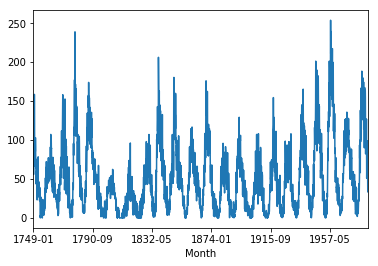

In [1]:
# Load sunspot data
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('sunspots.csv', header=0)
print(series.head())
series.plot()
pyplot.show()

Running the example prints the first 5 rows of data. The dataset is also plotted.

## Train-Test Split
You can split your dataset into training and testing subsets.

Your model can be prepared on the training dataset and predictions can be made and evaluated for the test dataset.

This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets. Depending on the amount of data you have available and the amount of data required, you can use splits of 50-50, 70-30 and 90-10.

It is straightforward to split data in Python.

After loading the dataset as a Pandas Series, we can extract the NumPy array of data values. The split point can be calculated as a specific index in the array. All records up to the split point are taken as the training dataset and all records from the split point to the end of the list of observations are taken as the test set.

Below is an example of this in Python using a split of 66-34.

In [2]:
from pandas import Series
series = Series.from_csv('sunspots.csv', header=0)
X = series.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 2821
Training Observations: 1861
Testing Observations: 960


Running the example prints the size of the loaded dataset and the size of the train and test sets created from the split.

We can make this visually by plotting the training and test sets using different colors.

Observations: 2821
Training Observations: 1861
Testing Observations: 960


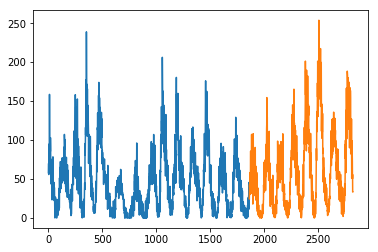

In [3]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('sunspots.csv', header=0)
X = series.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

Running the example plots the training dataset as blue and the test dataset as orange.

Using a train-test split method to evaluate machine learning models is fast. Preparing the data is simple and intuitive and only one model is created and evaluated.

It is useful when you have a large amount of data so that both training and tests sets are representative of the original problem.

Next, we will look at repeating this process multiple times.

## Multiple Train-Test Splits
We can repeat the process of splitting the time series into train and test sets multiple times.

This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data.

We could do this manually by repeating the process described in the previous section with different split points.

Alternately, the scikit-learn library provides this capability for us in the *TimeSeriesSplit* object.

You must specify the number of splits to create and the *TimeSeriesSplit* to return the indexes of the train and test observations for each requested split.

The total number of training and test observations are calculated each split iteration (i) as follows:

In [ ]:
training_size = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)
test_size = n_samples / (n_splits + 1)

Where *n_samples* is the total number of observations and *n_splits* is the total number of splits.

Let’s make this concrete with an example. Assume we have 100 observations and we want to create 2 splits.

For the first split, the train and test sizes would be calculated as:

In [ ]:
train = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)
train = 1 * 100 / (2 + 1) + 100 % (2 + 1)
train = 33.3 or 33
 
test = n_samples / (n_splits + 1)
test = 100 / (2 + 1)
test = 33.3 or 33

Or the first 33 records are used for training and the next 33 records are used for testing.

The second split is calculated as follows:

In [ ]:
train = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)
train = 2 * 100 / (2 + 1) + 100 % (2 + 1)
train = 66.6 or 67
 
test = n_samples / (n_splits + 1)
test = 100 / (2 + 1)
test = 33.3 or 33

Or, the first 67 records are used for training and the remaining 33 records are used for testing.

You can see that the test size stays consistent. This means that performance statistics calculated on the predictions of each trained model will be consistent and can be combined and compared. It provides an apples-to-apples comparison.

What differs is the number of records used to train the model each split, offering a larger and larger history to work with. This may make an interesting aspect of the analysis of results. Alternately, this too could be controlled by holding the number of observations used to train the model consistent and only using the same number of the most recent (last) observations in the training dataset each split to train the model, 33 in this contrived example.

Let’s look at how we can apply the TimeSeriesSplit on our sunspot data.

The dataset has 2,820 observations. Let’s create 3 splits for the dataset. Using the same arithmetic above, we would expect the following train and test splits to be created:

* **Split 1**: 705 train, 705 test
* **Split 2**: 1,410 train, 705 test
* **Split 3**: 2,115 train, 705 test

As in the previous example, we will plot the train and test observations using separate colors. In this case, we will have 3 splits, so that will be 3 separate plots of the data.

Observations: 1411
Training Observations: 706
Testing Observations: 705
Observations: 2116
Training Observations: 1411
Testing Observations: 705
Observations: 2821
Training Observations: 2116
Testing Observations: 705


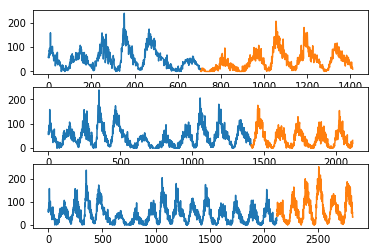

In [4]:
from pandas import Series
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
series = Series.from_csv('sunspots.csv', header=0)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
	train = X[train_index]
	test = X[test_index]
	print('Observations: %d' % (len(train) + len(test)))
	print('Training Observations: %d' % (len(train)))
	print('Testing Observations: %d' % (len(test)))
	pyplot.subplot(310 + index)
	pyplot.plot(train)
	pyplot.plot([None for i in train] + [x for x in test])
	index += 1
pyplot.show()

Running the example prints the number and size of the train and test sets for each split.

We can see the number of observations in each of the train and test sets for each split match the expectations calculated using the simple arithmetic above.

The plot also shows the 3 splits and the growing number of total observations in each subsequent plot.

Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data.

A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set.

This may not be realistic as models can be retrained as new daily or monthly observations are made available. This concern is addressed in the next section.

## Walk Forward Validation
In practice, we very likely will retrain our model as new data becomes available.

This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption.

There are few decisions to make:

1. **Minimum Number of Observations**. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
2. **Sliding or Expanding Window**. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.

After a sensible configuration is chosen for your test-setup, models can be trained and evaluated.

1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
2. The model makes a prediction for the next time step.
3. The prediction is stored or evaluated against the known value.
4. The window is expanded to include the known value and the process is repeated (go to step 1.)

Because this methodology involves moving along the time series one-time step at a time, it is often called Walk Forward Testing or Walk Forward Validation. Additionally, because a sliding or expanding window is used to train a model, this method is also referred to as Rolling Window Analysis or a Rolling Forecast.

This capability is currently not available in scikit-learn, although you could contrive the same effect with a carefully configured TimeSeriesSplit.

Below is an example of how to split data into train and test sets using the Walk Forward Validation method.

In [5]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('sunspots.csv', header=0)
X = series.values
n_train = 500
n_records = len(X)
for i in range(n_train, n_records):
	train, test = X[0:i], X[i:i+1]
	print('train=%d, test=%d' % (len(train), len(test)))

train=500, test=1
train=501, test=1
train=502, test=1
train=503, test=1
train=504, test=1
train=505, test=1
train=506, test=1
train=507, test=1
train=508, test=1
train=509, test=1
train=510, test=1
train=511, test=1
train=512, test=1
train=513, test=1
train=514, test=1
train=515, test=1
train=516, test=1
train=517, test=1
train=518, test=1
train=519, test=1
train=520, test=1
train=521, test=1
train=522, test=1
train=523, test=1
train=524, test=1
train=525, test=1
train=526, test=1
train=527, test=1
train=528, test=1
train=529, test=1
train=530, test=1
train=531, test=1
train=532, test=1
train=533, test=1
train=534, test=1
train=535, test=1
train=536, test=1
train=537, test=1
train=538, test=1
train=539, test=1
train=540, test=1
train=541, test=1
train=542, test=1
train=543, test=1
train=544, test=1
train=545, test=1
train=546, test=1
train=547, test=1
train=548, test=1
train=549, test=1
train=550, test=1
train=551, test=1
train=552, test=1
train=553, test=1
train=554, test=1
train=555,

train=2014, test=1
train=2015, test=1
train=2016, test=1
train=2017, test=1
train=2018, test=1
train=2019, test=1
train=2020, test=1
train=2021, test=1
train=2022, test=1
train=2023, test=1
train=2024, test=1
train=2025, test=1
train=2026, test=1
train=2027, test=1
train=2028, test=1
train=2029, test=1
train=2030, test=1
train=2031, test=1
train=2032, test=1
train=2033, test=1
train=2034, test=1
train=2035, test=1
train=2036, test=1
train=2037, test=1
train=2038, test=1
train=2039, test=1
train=2040, test=1
train=2041, test=1
train=2042, test=1
train=2043, test=1
train=2044, test=1
train=2045, test=1
train=2046, test=1
train=2047, test=1
train=2048, test=1
train=2049, test=1
train=2050, test=1
train=2051, test=1
train=2052, test=1
train=2053, test=1
train=2054, test=1
train=2055, test=1
train=2056, test=1
train=2057, test=1
train=2058, test=1
train=2059, test=1
train=2060, test=1
train=2061, test=1
train=2062, test=1
train=2063, test=1
train=2064, test=1
train=2065, test=1
train=2066, 

Running the example simply prints the size of the training and test sets created. We can see the train set expanding teach time step and the test set fixed at one time step ahead.

Within the loop is where you would train and evaluate your model.

You can see that many more models are created.

This has the benefit again of providing a much more robust estimation of how the chosen modeling method and parameters will perform in practice. This improved estimate comes at the computational cost of creating so many models.

This is not expensive if the modeling method is simple or dataset is small (as in this example), but could be an issue at scale. In the above case, 2,820 models would be created and evaluated.

As such, careful attention needs to be paid to the window width and window type. These could be adjusted to contrive a test harness on your problem that is significantly less computationally expensive.

Walk-forward validation is the gold standard of model evaluation. It is the k-fold cross validation of the time series world and is recommended for your own projects.

## Summary
In this tutorial, you discovered how to backtest machine learning models on time series data with Python.

Specifically, you learned:

* About the importance of evaluating the performance of models on unseen or out-of-sample data.
* How to create train-test splits of time series data, and how to create multiple such splits automatically.
* How to use walk-forward validation to provide the most realistic test harness for evaluating your models.